In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/GAN')

In [3]:
!ls

cgan_mnist.ipynb  gan_cifar10.ipynb  gan_code.ipynb  gan_mnist_one_character.ipynb


In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
%matplotlib inline

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [7]:
z_dim = 64
batch_size = 128
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

fixed_noise = get_noise(batch_size, z_dim, device=device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 140109629.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 148998393.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 117321900.60it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5903479.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [9]:
def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=128):
    for images, _ in dataloader:
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([128, 1, 28, 28])


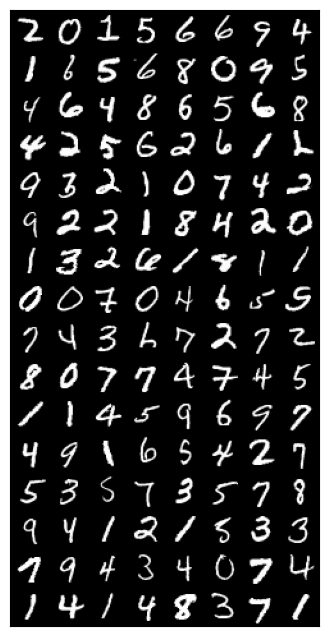

In [10]:
show_batch(dataloader)

In [11]:
mnist_shape = (1, 28, 28)
n_classes = 10
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan =  mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.get_generator_block(z_dim,
                                     hidden_dim * 4,
                                     kernel_size=3,
                                     stride=2),

            self.get_generator_block(hidden_dim * 4,
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),

            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),

            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)
        )

    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )

    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),

            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),

            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),
        )

    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )

    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )

    def forward(self, image):
        return self.disc(image)

In [15]:
lr = 3e-4
beta_1 = 0.5
beta_2 = 0.999

generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

criterion = nn.BCEWithLogitsLoss()

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


gen = Generator(z_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
gen = gen.apply(weights_init)

disc  = Discriminator(im_chan = discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = disc.apply(weights_init)

In [16]:
import torch.nn.functional as F

def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels,n_classes)

def combine_vectors(x, y):
    combined = torch.cat((x.float(),y.float()) , 1)
    return combined

In [17]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    plt.show()

In [18]:
n_epochs = 10
cur_step = 0
total_steps = 0
cur_step = 0

D_mean_losses = []
G_mean_losses = []

generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False
display_step = 5
fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False


fixed_one_hot_labels = get_one_hot_labels(torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device), n_classes)
fixed_noise = get_noise(10, z_dim, device=device)
fixed_noise_and_labels = combine_vectors(fixed_noise, fixed_one_hot_labels)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0/10 Total Steps:469	Loss_D : 0.243196	Loss_G : 1.996731	Loss_D_Mean : 0.212364	Loss_G_Mean : 2.472423	


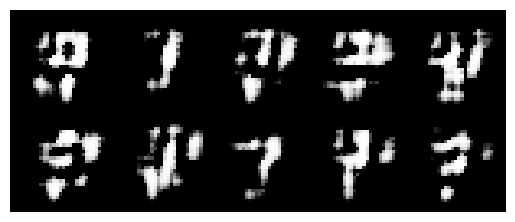

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1/10 Total Steps:938	Loss_D : 0.593653	Loss_G : 0.912760	Loss_D_Mean : 0.509613	Loss_G_Mean : 1.337685	


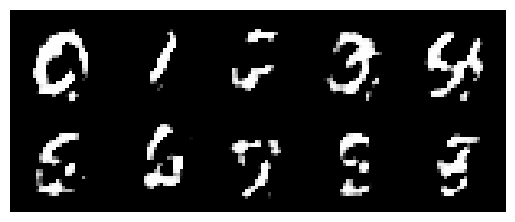

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2/10 Total Steps:1407	Loss_D : 0.552496	Loss_G : 1.550928	Loss_D_Mean : 0.559499	Loss_G_Mean : 1.076681	


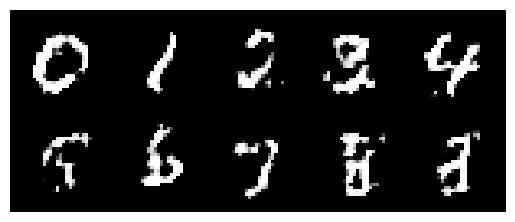

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3/10 Total Steps:1876	Loss_D : 0.629067	Loss_G : 0.901670	Loss_D_Mean : 0.595863	Loss_G_Mean : 1.003162	


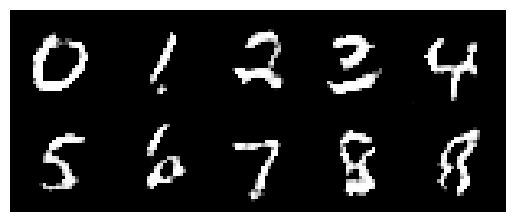

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4/10 Total Steps:2345	Loss_D : 0.571432	Loss_G : 0.881684	Loss_D_Mean : 0.626441	Loss_G_Mean : 0.921695	


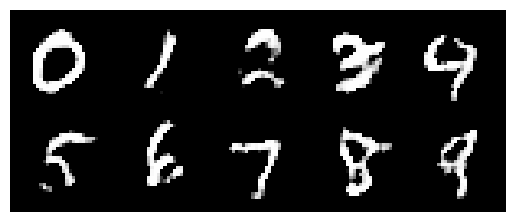

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5/10 Total Steps:2814	Loss_D : 0.590015	Loss_G : 0.865224	Loss_D_Mean : 0.616569	Loss_G_Mean : 0.924843	


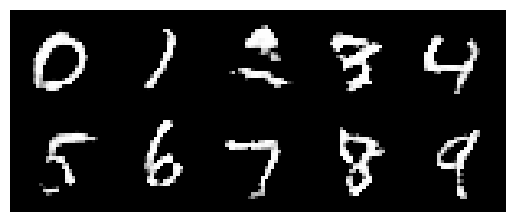

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6/10 Total Steps:3283	Loss_D : 0.595860	Loss_G : 1.216624	Loss_D_Mean : 0.613801	Loss_G_Mean : 0.937666	


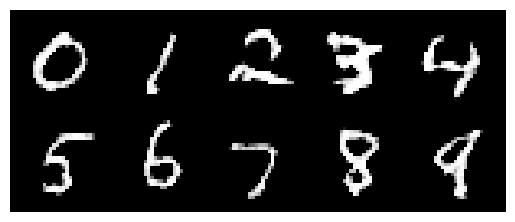

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7/10 Total Steps:3752	Loss_D : 0.600112	Loss_G : 0.923982	Loss_D_Mean : 0.626688	Loss_G_Mean : 0.917299	


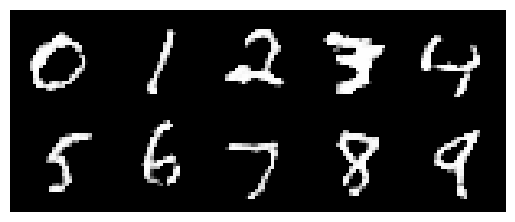

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8/10 Total Steps:4221	Loss_D : 0.671173	Loss_G : 0.898812	Loss_D_Mean : 0.632883	Loss_G_Mean : 0.901610	


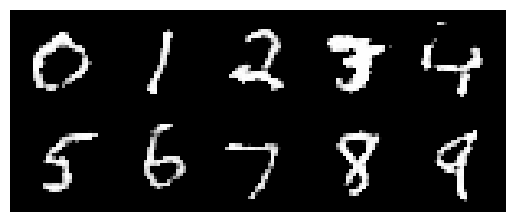

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9/10 Total Steps:4690	Loss_D : 0.602508	Loss_G : 0.757197	Loss_D_Mean : 0.641436	Loss_G_Mean : 0.887951	


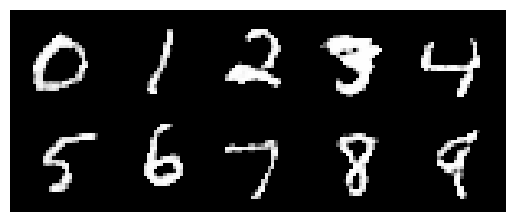

In [20]:
for epoch in range(n_epochs):

    cur_step = 0
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ## discriminator train step
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        noise_and_labels =  combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]
        ## generator train step
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()

        gen_opt.step()
        generator_losses += [gen_loss.item()]

        cur_step += 1
        total_steps += 1

        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Loss_D : {disc_loss.item():.6f}\t"
        print_val += f"Loss_G : {gen_loss.item():.6f}\t"
        print(print_val, end='\r',flush = True)

    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    disc_mean = sum(discriminator_losses[-cur_step:]) / cur_step

    D_mean_losses.append(disc_mean)
    G_mean_losses.append(gen_mean)

    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Loss_D : {disc_loss.item():.6f}\t"
    print_val += f"Loss_G : {gen_loss.item():.6f}\t"
    print_val += f"Loss_D_Mean : {disc_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)

    fake = gen(fixed_noise_and_labels)
    show_tensor_images(fake, show_fig=True, epoch=epoch)
#     show_tenor_images(real)
    cur_step = 0

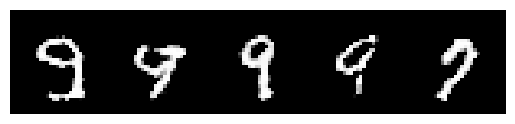

In [25]:
def generate_images_for_class(class_label, num_images):
    """Generate images for a given class label."""
    # Convert class label to one-hot encoding
    one_hot_label = get_one_hot_labels(torch.tensor([class_label] * num_images), n_classes).to(device)

    # Generate noise
    noise = get_noise(num_images, z_dim, device=device)

    # Combine noise and one-hot label
    noise_and_labels = combine_vectors(noise, one_hot_label)

    # Generate images using the generator model
    with torch.no_grad():
        fake_images = gen(noise_and_labels).cpu()

    # Show the generated images
    show_tensor_images(fake_images, num_images=num_images, show_fig=True)

# Example usage:
class_label = 9  # Specify the class label for which you want to generate images
num_images = 5   # Number of images to generate
generate_images_for_class(class_label, num_images)


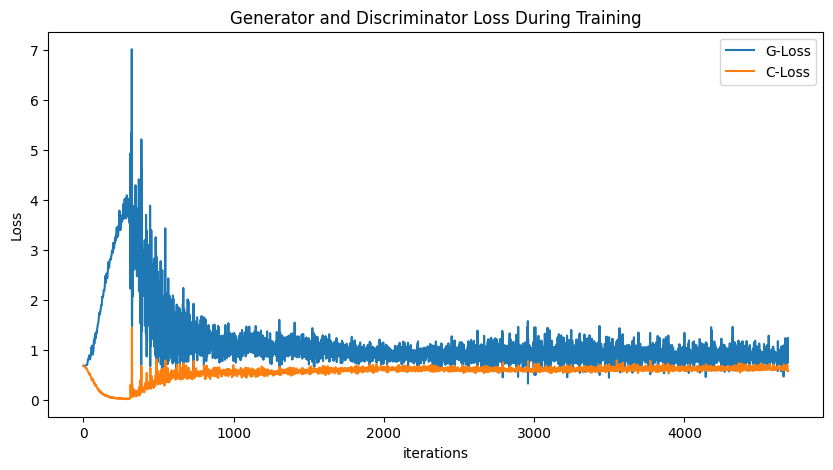

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(discriminator_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

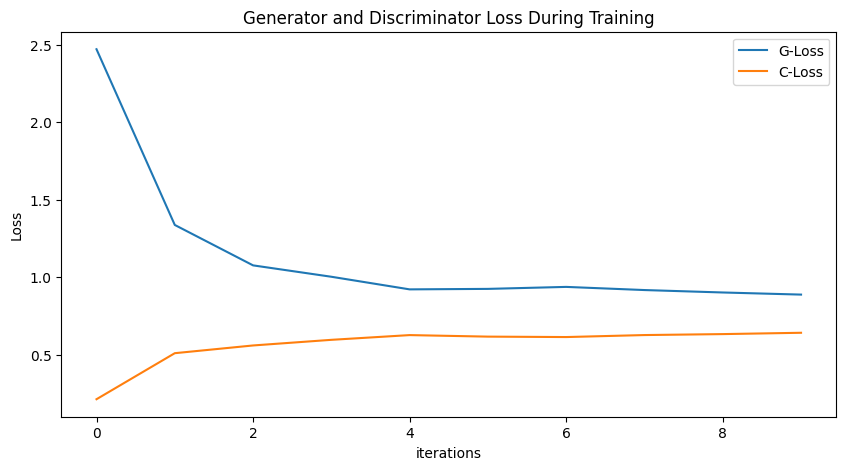

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(D_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()